In [23]:
import quimb.tensor as qtn
import quimb as qu
from utils import *

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


The task in this notebook is to find the ground state energy of a given ising model hamiltonian using the update algorithm on tensor networks.
For the update we use the update algorithm implemented in the `quimb` library. But first let's quickly review the basics of the update algorithm.

The imaginary time evolution (ITE) operator is defined as follows:
$$
U(\tau) = e^{-\tau H}
$$
For $\tau \rightarrow \infty$ the ITE operator maps any state to the ground state of the hamiltonian $H$. The ITE operator is not unitary (so, it has actually nothing to do with time evolution), but it works like a softmax (with $\tau = -\beta$) to pick out the ground state.
$$
\ket{\psi_0} \propto \lim_{\tau \rightarrow \infty} U(\tau) \ket{\psi_\text{init}}
$$
To avoid huge numbers in the exponential, we iterate the ITE operator in small steps $\delta \tau$ until convergence.
$$
\psi_{\tau + \delta \tau} = \frac{U(\delta \tau) \psi_{\tau}}{\| U(\delta \tau) \psi_{\tau} \|_2}
$$
Furthermore, the update algorithm uses the fact that a matrix exponential can be decomposed into a product of exponentials of the sum of the matrices if the matrices commute: $e^{A + B} = e^A e^B \iff [A, B] = 0$.
So, if we assume that the hamiltonian can be decomposed into two commuting parts $H = \sum_i H_i$ (e.g. that operate on different parts of the system), we can decompose the ITE operator as follows:
$$
U(\delta \tau) = e^{-\delta \tau H} = e^{-\delta \tau \sum_i H_i} = \prod_i e^{-\delta \tau H_i}
$$

The update algorithm is implemented in the `quimb` library. We can use it to find the ground state energy of a given hamiltonian. Let's try it out on a simple hamiltonian:
$$
H = \sigma^z_1 \sigma^z_2 + \sigma^z_2 \sigma^z_3 + \sigma^z_3 \sigma^z_4
$$
The ground state energy is $E_0 = -3$ and the ground state is $\ket{\psi_0} = \ket{0101}$.

In [193]:
ising(3, J=0.25, h=0, g=0), ising(3, J=0, g=0.5, h=0)

('0.25*(ZZI + IZZ)', 'ZZI + IZZ + 0.5*(XII + IXI + IIX)')

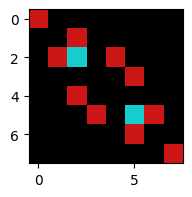

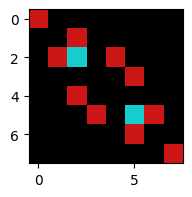

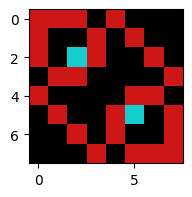

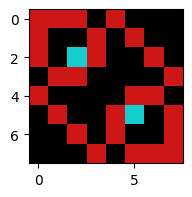

In [185]:
H1 = qu.ham_heis(n=3, j=(1, 1, 1), sparse=False).astype(complex)
imshow(H1, figsize=(2,2))
H2 = parse_hamiltonian('0.25*(ZZI + IZZ + XXI + IXX + YYI + IYY)')
imshow(H2, figsize=(2,2))

H1 = qu.ham_heis(n=3, j=(0, 0, 1), b=(-1, 0, 0), sparse=False).astype(complex)
imshow(H1, figsize=(2,2))
H2 = parse_hamiltonian('0.25*(ZZI + IZZ)') + parse_hamiltonian('0.5*(XII + IXI + IIX)')  # nasty bug
imshow(H2, figsize=(2,2))

In [194]:
# Find the ground state of a Hamiltonian using quimb

# Create a Hamiltonian
H = qu.ham_heis(n=3, j=(0, 0, 1), b=(1,0,1), sparse=False).astype(complex)
# Find the ground state
qu.groundenergy(H)

-1.966012761826012

In [239]:
ham2 = qu.ham_heis_2D(*n, sparse=True)

In [249]:
qu.ham_heis_2D(*n, sparse=True)

<512x512 sparse matrix of type '<class 'numpy.float64'>'
	with 3440 stored elements in Compressed Sparse Row format>

Text(0.5, 0, 'Iteration')

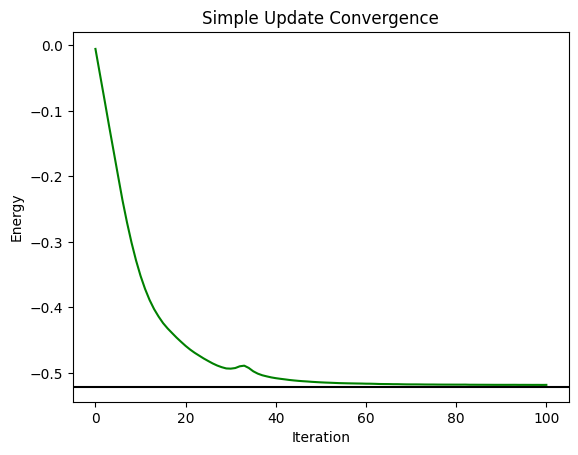

In [269]:
n = (3,2)

ham_full = qu.ham_heis_2D(*n, sparse=False)
ham_local = qtn.LocalHam2D(*n, H2=qu.ham_heis(2))

energy_exact = qu.groundenergy(ham_full) / np.prod(n)

psi0 = qtn.PEPS.rand(*n, bond_dim=4, seed=666)
fu = qtn.SimpleUpdate(
    psi0 = psi0,
    ham = ham_local,
    chi = 16,
    compute_energy_every = 1,
    compute_energy_per_site = True,
    keep_best = True,
    progbar = True
)
fu.evolve(100, tau=0.1)

plt.plot(fu.its, fu.energies, color='green')
plt.axhline(energy_exact, color='black')
plt.title('Simple Update Convergence')
plt.ylabel('Energy')
plt.xlabel('Iteration')